In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

custom_colors = ["#c8e7ff","#deaaff", "#f72585","#d100d1"]

In [2]:
# Load the data
df = pd.read_csv('data/Preprocessed data.csv')
df.head()

,"Q1r1 - To begin, what is your age?","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Streaming media box or over-the-top box","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription)","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Blu-ray disc player/DVD player","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Gaming console","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Portable video game player","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Computer network/router in your home for wireless computer/laptop usage","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Desktop computer","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Laptop computer","Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Tablet",...,QNEW3 - What is your employment status?_Retired,QNEW3 - What is your employment status?_Self-employed,QNEW3 - What is your employment status?_Student,QNEW3 - What is your employment status?_Unemployed,"Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential._$100,000 to $299,999","Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential._$30,000 to $49,999","Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential._$50,000 to $99,999","Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential._Do not know","Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential._Less than $29,999","Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential._More than $300,000"
0,26.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,25.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,28.0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,16.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,32.0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


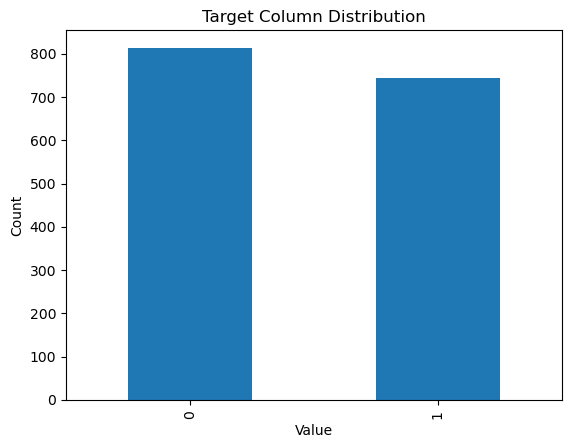

In [3]:
target_col = 'Q29 - You said that you subscribe to home Internet access, how much more would you be willing to pay to receive double your download speed?'

# Count the number of occurrences of each unique value in the target column
counts = df[target_col].value_counts()

# Create a bar plot of the counts
counts.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Target Column Distribution')
plt.xlabel('Value')
plt.ylabel('Count')

# Display the plot
plt.show()

In [4]:
def train_model(X, y, model):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_accs = []
    test_accs = []
    predicted_targets = np.array([])
    actual_targets = np.array([])

    for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_predictions)
        test_acc = accuracy_score(y_test, test_predictions)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        predicted_targets = np.append(predicted_targets, test_predictions)
        actual_targets = np.append(actual_targets, y_test)

    return train_accs, test_accs, predicted_targets, actual_targets

X = df.drop(target_col, axis=1)
y = df[target_col]

models = [
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("SVM", SVC()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Decision Tree", BaggingClassifier(base_estimator=DecisionTreeClassifier())),
    ("Boosted Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Random Forest", RandomForestClassifier()),
    ("Voting Classification", VotingClassifier(estimators=[('lr', LogisticRegression()), ('knn', KNeighborsClassifier()), ('svc', SVC()), ('dt', DecisionTreeClassifier()), ('rf', RandomForestClassifier())])),
    ("Neural Network", MLPClassifier())
]

for name, model in models:

    train_accs, test_accs, predicted_targets, actual_targets = train_model(X, y, model)

    # calculating the average accuracy over all folds for each model
    train_avg_acc = np.mean(train_accs)
    test_avg_acc = np.mean(test_accs)

    print("\n" + name +  " Accuracy (Train) across all folds: ", train_avg_acc)
    print( name +  " Accuracy (Test) across all folds: ", test_avg_acc)

ValueError: could not convert string to float: 'Rarely (10%-50% of the time)'

In [ ]:
class_names = [0, 1]
train_accs, test_accs, predicted_targets, actual_targets  = train_model(X, y, models[1][1])
cm = confusion_matrix(actual_targets, predicted_targets)

classes = [0,1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot confusion matrix
im = ax[0].imshow(cm, cmap=plt.get_cmap('Blues'))
ax[0].set_title("Confusion matrix")
fig.colorbar(im, ax=ax[0])

tick_marks = np.arange(len(classes))
ax[0].set_xticks(tick_marks)
ax[0].set_xticklabels(classes)
ax[0].set_yticks(tick_marks)
ax[0].set_yticklabels(classes)
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

fmt = 'd'
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax[0].text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# Calculate precision, recall, and F1 score, AUC-ROC score
precision = precision_score(actual_targets, predicted_targets)
recall = recall_score(actual_targets, predicted_targets)
f1 = f1_score(actual_targets, predicted_targets)

# Plot ROC curve
fpr, tpr, _ = roc_curve(actual_targets, predicted_targets)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend(loc="lower right")

plt.suptitle("Model: Logistic Regression")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# Create a logistic regression model
lr = LogisticRegression()

# Perform k-fold cross-validation with permutation feature importance
cv_results = cross_validate(lr, X, y, cv=5, scoring='accuracy',
                            return_estimator=True, return_train_score=True)

# Compute permutation feature importance for each fold
importance_scores = []
for estimator in cv_results['estimator']:
    result = permutation_importance(estimator, X, y, scoring='accuracy',
                                    n_repeats=10, random_state=0)
    importance_scores.append(result.importances_mean)

# Aggregate feature importance scores across folds
mean_importance = np.mean(importance_scores, axis=0)
std_importance = np.std(importance_scores, axis=0)

# Sort features by mean importance score
feature_importance = sorted(zip(X.columns, mean_importance, std_importance),
                            key=lambda x: x[1], reverse=True)

In [ ]:
# Get feature names and importance scores
features = [f[0] for f in feature_importance[:20]]
importance = [f[1] for f in feature_importance[:20]]
std = [f[2] for f in feature_importance[:20]]

# Plot feature importance as a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(features, importance, xerr=std, align='center')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()